In [495]:
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from statsmodels.graphics.gofplots import qqplot
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

pd.options.display.float_format = '{:,.2f}'.format

In [496]:
country_list = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
country_list = country_list[["name", "alpha-3", "region", "sub-region"]]
country_list[country_list["name"].str.startswith("U")]

,name,alpha-3,region,sub-region
231,Uganda,UGA,Africa,Sub-Saharan Africa
232,Ukraine,UKR,Europe,Eastern Europe
233,United Arab Emirates,ARE,Asia,Western Asia
234,United Kingdom of Great Britain and Northern I...,GBR,Europe,Northern Europe
235,United States of America,USA,Americas,Northern America
236,United States Minor Outlying Islands,UMI,Oceania,Micronesia
237,Uruguay,URY,Americas,Latin America and the Caribbean
238,Uzbekistan,UZB,Asia,Central Asia


In [497]:
years_to_drop = ["{:d}".format(year) for year in range(1960, 2000)]

agricaltural_land_perc = pd.read_csv("Veri Setleri/API_AG.LND.AGRI.ZS_DS2_en_csv_v2_4669757/API_AG.LND.AGRI.ZS_DS2_en_csv_v2_4669757.csv", skiprows=4)
agricaltural_land_perc.drop([*(agricaltural_land_perc.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
agricaltural_land_perc = agricaltural_land_perc.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)

In [498]:
forest_land_perc = pd.read_csv("Veri Setleri/API_AG.LND.FRST.ZS_DS2_en_csv_v2_4701080/API_AG.LND.FRST.ZS_DS2_en_csv_v2_4701080.csv", skiprows=4)
forest_land_perc.drop([*(forest_land_perc.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
forest_land_perc = forest_land_perc.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)

In [499]:
electric_access_perc = pd.read_csv("Veri Setleri/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_4695288/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_4695288.csv", skiprows=4)
electric_access_perc.drop([*(electric_access_perc.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
electric_access_perc = electric_access_perc.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)

In [500]:
co2_emission_kt = pd.read_csv("Veri Setleri/API_EN.ATM.CO2E.KT_DS2_en_csv_v2_4701269/API_EN.ATM.CO2E.KT_DS2_en_csv_v2_4701269.csv", skiprows=4)
co2_emission_kt.drop([*(co2_emission_kt.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
co2_emission_kt = co2_emission_kt.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)

In [501]:
agri_forest_value_added = pd.read_csv("Veri Setleri/API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_4677103/API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_4677103.csv", skiprows=4)
agri_forest_value_added.drop([*(agri_forest_value_added.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
agri_forest_value_added = agri_forest_value_added.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)

In [502]:
industry_value_added = pd.read_csv("Veri Setleri/API_NV.IND.TOTL.ZS_DS2_en_csv_v2_4695695/API_NV.IND.TOTL.ZS_DS2_en_csv_v2_4695695.csv", skiprows=4)
industry_value_added.drop([*(industry_value_added.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
industry_value_added = industry_value_added.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)

In [503]:
gdp_per_capita = pd.read_csv("Veri Setleri/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_4701206/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_4701206.csv", skiprows=4)
gdp_per_capita.drop([*(gdp_per_capita.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
gdp_per_capita = gdp_per_capita.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)

In [504]:
total_pop = pd.read_csv("Veri Setleri/API_SP.POP.TOTL_DS2_en_csv_v2_4701113/API_SP.POP.TOTL_DS2_en_csv_v2_4701113.csv", skiprows=4)
total_pop.drop([*(total_pop.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
total_pop = total_pop.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)

In [505]:
dataframe_list = [agricaltural_land_perc, forest_land_perc, electric_access_perc, co2_emission_kt, agri_forest_value_added, industry_value_added, gdp_per_capita, total_pop]
dataframe_names = ["agricaltural_land_perc", "forest_land_perc", "electric_access_perc", "co2_emission_kt", "agri_forest_value_added", "industry_value_added", "gdp_per_capita", "total_pop"]
all_data_df = pd.DataFrame(columns=['alpha-3', 'region', 'agricaltural_land_perc', 'forest_land_perc',
       'electric_access_perc', 'co2_emission_kt', 'agri_forest_value_added',
       'industry_value_added', 'gdp_per_capita', 'total_pop', "data_year"])

for year in ["{:d}".format(year) for year in range(2000, 2021)]:
    selected_columns = ["Country Code", year]
    single_year_values = country_list[["alpha-3", "region"]]
    for dataframe, name in zip(dataframe_list, dataframe_names):
        single_year_values = single_year_values.merge(dataframe[selected_columns], how="inner", left_on="alpha-3", right_on="Country Code")
        single_year_values.drop("Country Code", axis=1, inplace=True)
        single_year_values.rename({year: name}, inplace=True, axis=1)
        single_year_values["data_year"] = int(year)
    all_data_df = pd.concat([all_data_df, single_year_values], axis=0)

all_data_df["transformed_co2_emission_kt"] = np.log(all_data_df.co2_emission_kt)

In [506]:
display(all_data_df[all_data_df["data_year"] == 2019].describe())

,agricaltural_land_perc,forest_land_perc,electric_access_perc,co2_emission_kt,agri_forest_value_added,industry_value_added,gdp_per_capita,total_pop,transformed_co2_emission_kt
count,209.00,213.00,214.00,191.00,192.00,193.00,206.00,214.00,191.00
mean,37.27,31.94,86.22,"177,392.72",9.80,25.23,"18,760.04","35,769,893.24",9.46
std,21.91,24.30,24.26,"877,397.77",9.99,11.13,"27,523.57","139,025,474.25",2.44
min,0.54,0.00,6.71,10.00,0.02,4.23,223.86,"10,764.00",2.30
25%,19.12,11.07,84.07,"2,625.00",2.09,17.85,"2,350.47","799,804.00",7.87
50%,38.48,30.94,99.98,"12,450.00",6.41,24.05,"7,332.32","6,816,581.00",9.43
75%,52.46,50.26,100.00,"68,125.00",15.85,31.49,"23,437.39","25,591,054.75",11.13
max,80.75,97.49,100.00,"10,707,219.73",58.15,62.52,"189,487.15","1,407,745,000.00",16.19


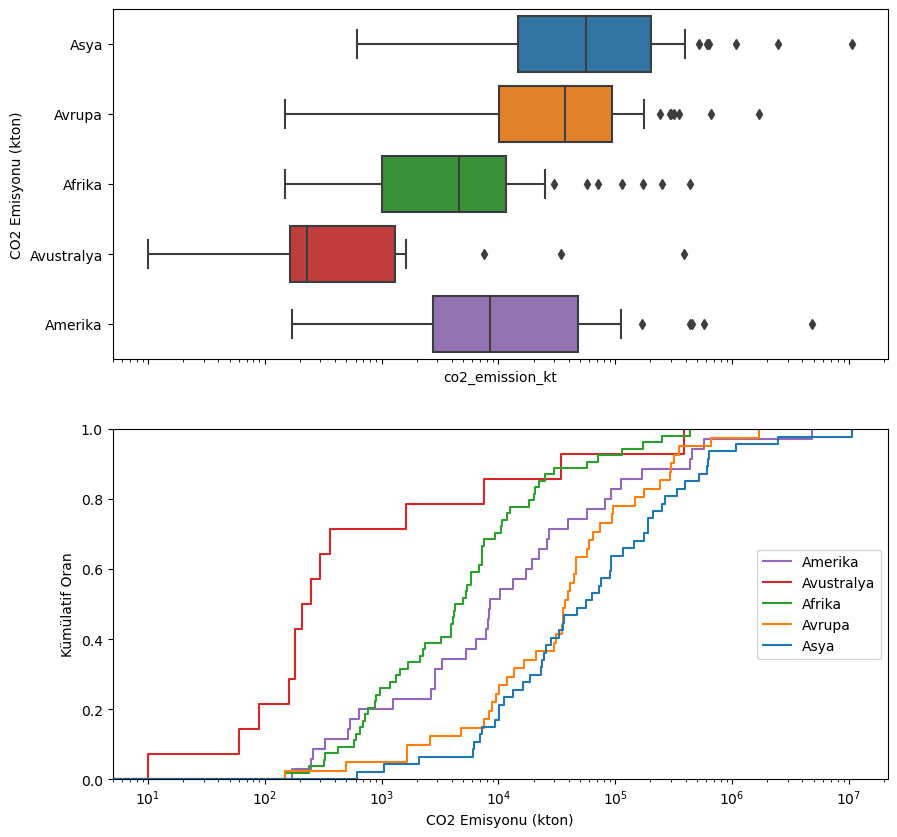

In [507]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

filter_year = all_data_df["data_year"] == 2019
sns.boxplot(data=all_data_df[filter_year], y="region", x="co2_emission_kt", ax=ax[0])
ax[0].set_ylabel("CO2 Emisyonu (kton)")
ax[0].set_yticks(labels=["Asya", "Avrupa", "Afrika", "Avustralya", "Amerika"], ticks=[0,1,2,3,4])

sns.ecdfplot(data=all_data_df[filter_year], x="co2_emission_kt", hue="region", legend=False, ax=ax[1])
ax[1].semilogx()
ax[1].set_xlabel("CO2 Emisyonu (kton)")
ax[1].set_ylabel("Kümülatif Oran")
ax[1].legend(labels=np.flip(["Asya", "Avrupa", "Afrika", "Avustralya", "Amerika"]), loc="center right")
fig.set_size_inches(10,10)

In [508]:
regions = all_data_df.region.unique()
emission_by_country_2019 = {}

for region in regions:
    emissions_mask = np.logical_and(all_data_df["data_year"] == 2019, all_data_df["region"].isin([region]))
    emission_by_country_2019[region] = all_data_df[emissions_mask]["co2_emission_kt"].dropna()

f_stat, p_value = stats.f_oneway(emission_by_country_2019["Asia"], emission_by_country_2019["Europe"], emission_by_country_2019["Oceania"], emission_by_country_2019["Africa"], emission_by_country_2019["Americas"])
display("CO2 emisyon dağılımı arasında kıtalara bağlı bir farklılık olup olmadığı üzere yapılan ANOVA analizinin sonucu olarak F değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(f_stat, p_value))


#‘less’: the mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample.
t_stat, p_value = stats.ttest_ind(emission_by_country_2019["Americas"], emission_by_country_2019["Asia"], alternative="less", equal_var=False)
display("Asya ve Avrupa CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(t_stat, p_value))

'CO2 emisyon dağılımı arasında kıtalara bağlı bir farklılık olup olmadığı üzere yapılan ANOVA analizinin sonucu olarak F değeri: 1.471 ve p değeri: 0.213 olarak elde edilmiştir.'

'Asya ve Avrupa CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: -0.824 ve p değeri: 0.206 olarak elde edilmiştir.'

In [509]:
regions = all_data_df.region.unique()
emission_by_country_2019 = {}

for region in regions:
    emissions_mask = np.logical_and(all_data_df["data_year"] == 2019, all_data_df["region"].isin([region]))
    emission_by_country_2019[region] = all_data_df[emissions_mask]["transformed_co2_emission_kt"].dropna()

f_stat, p_value = stats.f_oneway(emission_by_country_2019["Asia"], emission_by_country_2019["Europe"], emission_by_country_2019["Oceania"], emission_by_country_2019["Africa"], emission_by_country_2019["Americas"])
display("CO2 emisyon dağılımı arasında kıtalara bağlı bir farklılık olup olmadığı üzere yapılan ANOVA analizinin sonucu olarak F değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(f_stat, p_value))


#‘less’: the mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample.
t_stat, p_value = stats.ttest_ind(emission_by_country_2019["Europe"], emission_by_country_2019["Asia"], alternative="less", equal_var=False)
display("Asya ve Avrupa CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(t_stat, p_value))

#‘less’: the mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample.
t_stat, p_value = stats.ttest_ind(emission_by_country_2019["Americas"], emission_by_country_2019["Asia"], alternative="less", equal_var=False)
display("Asya ve Amerika CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(t_stat, p_value))

#‘less’: the mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample.
t_stat, p_value = stats.ttest_ind(emission_by_country_2019["Africa"], emission_by_country_2019["Asia"], alternative="less", equal_var=False)
display("Asya ve Afrika CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(t_stat, p_value))

#‘less’: the mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample.
t_stat, p_value = stats.ttest_ind(emission_by_country_2019["Oceania"], emission_by_country_2019["Asia"], alternative="less", equal_var=False)
display("Asya ve Avustralya CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(t_stat, p_value))

'CO2 emisyon dağılımı arasında kıtalara bağlı bir farklılık olup olmadığı üzere yapılan ANOVA analizinin sonucu olarak F değeri: 19.413 ve p değeri: 0.000 olarak elde edilmiştir.'

'Asya ve Avrupa CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: -1.443 ve p değeri: 0.076 olarak elde edilmiştir.'

'Asya ve Amerika CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: -3.296 ve p değeri: 0.001 olarak elde edilmiştir.'

'Asya ve Afrika CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: -6.679 ve p değeri: 0.000 olarak elde edilmiştir.'

'Asya ve Avustralya CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: -5.860 ve p değeri: 0.000 olarak elde edilmiştir.'

In [510]:
#‘greater’: the mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample.
t_stat, p_value = stats.ttest_ind(emission_by_country_2019["Europe"], emission_by_country_2019["Oceania"], alternative="greater", equal_var=False)
display("Avustralya ve Avrupa CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(t_stat, p_value))

#‘greater’: the mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample.
t_stat, p_value = stats.ttest_ind(emission_by_country_2019["Americas"], emission_by_country_2019["Oceania"], alternative="greater", equal_var=False)
display("Avustralya ve Amerika CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(t_stat, p_value))

#‘greater’: the mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample.
t_stat, p_value = stats.ttest_ind(emission_by_country_2019["Africa"], emission_by_country_2019["Oceania"], alternative="greater", equal_var=False)
display("Avustralya ve Afrika CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(t_stat, p_value))

#‘greater’: the mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample.
t_stat, p_value = stats.ttest_ind(emission_by_country_2019["Asia"], emission_by_country_2019["Oceania"], alternative="greater", equal_var=False)
display("Asya ve Avustralya CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(t_stat, p_value))

'Avustralya ve Avrupa CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: 5.084 ve p değeri: 0.000 olarak elde edilmiştir.'

'Avustralya ve Amerika CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: 3.505 ve p değeri: 0.001 olarak elde edilmiştir.'

'Avustralya ve Afrika CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: 2.712 ve p değeri: 0.008 olarak elde edilmiştir.'

'Asya ve Avustralya CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: 5.860 ve p değeri: 0.000 olarak elde edilmiştir.'

In [511]:
region_by_year_emission = all_data_df[["region", "data_year", "transformed_co2_emission_kt"]]
years = region_by_year_emission.data_year.unique()
countries = region_by_year_emission.region.unique()
p_values = {}
t_stats = {}

for region in countries:
    p_value_list = []
    t_stat_list = []
    for year in years[:-2]:
        year_mask = region_by_year_emission.data_year == year
        next_year_mask = region_by_year_emission.data_year == year+1
        region_mask = region_by_year_emission.region == region
        
        #‘less’: the mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample.
        t_stat, p_value = stats.ttest_ind(region_by_year_emission[np.logical_and(region_mask, year_mask)]["transformed_co2_emission_kt"].dropna(), 
                                                                   region_by_year_emission[np.logical_and(region_mask, next_year_mask)]["transformed_co2_emission_kt"].dropna(), 
                                                                       alternative="less", equal_var=False)
        p_value_list.append(p_value)
        t_stat_list.append(t_stat)
    p_values[region] = p_value_list
    t_stats[region] = t_stat_list

pd.DataFrame(p_values)

,Asia,Europe,Africa,Oceania,Americas
0,0.48,0.47,0.44,0.48,0.47
1,0.56,0.49,0.46,0.49,0.49
2,0.46,0.46,0.45,0.48,0.48
3,0.46,0.49,0.45,0.47,0.48
4,0.45,0.50,0.45,0.48,0.48
5,0.45,0.49,0.45,0.51,0.47
6,0.46,0.50,0.47,0.50,0.47
7,0.45,0.51,0.47,0.53,0.49
8,0.49,0.58,0.43,0.49,0.32
9,0.45,0.46,0.42,0.51,0.66


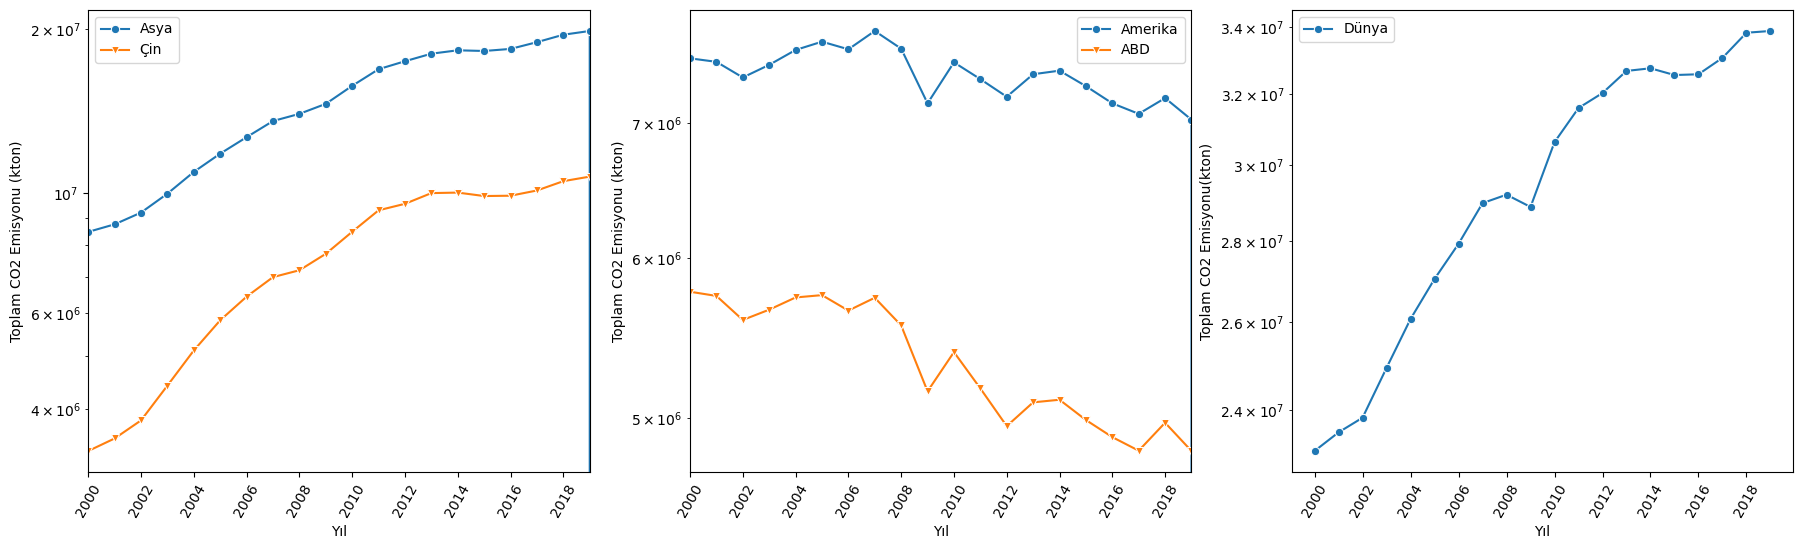

In [512]:
country_map = {
    "Europe": "Avrupa",
    "Oceania": "Avustralya",
    "Asia": "Asya",
    "Africa": "Afrika",
    "Americas": "Amerika"
}
region_by_year_emission = all_data_df.groupby(["region", "data_year"])["co2_emission_kt"].agg([np.sum, np.mean, np.std]).reset_index().replace({"region": country_map}).rename({"region": "Kıta"}, axis=1)

fig, ax = plt.subplots(ncols=3, nrows=1)

sns.lineplot(x=region_by_year_emission[region_by_year_emission.Kıta == "Asya"]["data_year"], y=region_by_year_emission[region_by_year_emission.Kıta == "Asya"]["sum"], label="Asya", marker="o", ax=ax[0])
sns.lineplot(x=all_data_df[all_data_df["alpha-3"] == "CHN"]["data_year"].values, y=all_data_df[all_data_df["alpha-3"] == "CHN"]["co2_emission_kt"].values, label="Çin", ax=ax[0], marker="v")
#sns.lineplot(x=all_data_df[all_data_df["alpha-3"] == "IND"]["data_year"].values, y=all_data_df[all_data_df["alpha-3"] == "IND"]["co2_emission_kt"].values, label="Hisdistan", ax=ax[0], marker="v")
#sns.lineplot(x=all_data_df[all_data_df["alpha-3"] == "JPN"]["data_year"].values, y=all_data_df[all_data_df["alpha-3"] == "JPN"]["co2_emission_kt"].values, label="Japonya", ax=ax[0], marker="v")

ax[0].legend()
ax[0].semilogy()
ax[0].set_xticks(ticks=range(2000, 2020, 2))
ax[0].set_xlim(2000, 2019)
ax[0].tick_params(axis="x", rotation=60)
ax[0].set_ylabel("Toplam CO2 Emisyonu (kton)")
ax[0].set_xlabel("Yıl")

sns.lineplot(x=region_by_year_emission[region_by_year_emission.Kıta == "Amerika"]["data_year"], y=region_by_year_emission[region_by_year_emission.Kıta == "Amerika"]["sum"], label="Amerika", marker="o", ax=ax[1])
sns.lineplot(x=all_data_df[all_data_df["alpha-3"] == "USA"]["data_year"].values, y=all_data_df[all_data_df["alpha-3"] == "USA"]["co2_emission_kt"].values, label="ABD", ax=ax[1], marker="v")
#sns.lineplot(x=all_data_df[all_data_df["alpha-3"] == "CAN"]["data_year"].values, y=all_data_df[all_data_df["alpha-3"] == "CAN"]["co2_emission_kt"].values, label="Kanada", ax=ax[1], marker="v")
#sns.lineplot(x=all_data_df[all_data_df["alpha-3"] == "MEX"]["data_year"].values, y=all_data_df[all_data_df["alpha-3"] == "MEX"]["co2_emission_kt"].values, label="Meksika", ax=ax[1], marker="v")
ax[1].legend()
ax[1].semilogy()
ax[1].set_xticks(ticks=range(2000, 2020, 2))
ax[1].set_xlim(2000, 2019)
ax[1].tick_params(axis="x", rotation=60)
ax[1].set_ylabel("Toplam CO2 Emisyonu (kton)")
ax[1].set_xlabel("Yıl")

emisson_by_year = all_data_df.groupby(["data_year"])["co2_emission_kt"].agg([np.sum, np.mean, np.std]).drop(labels=[2020], axis=0)

sns.lineplot(data=emisson_by_year, x="data_year", y="sum", label="Dünya", marker="o", ax=ax[2])

ax[2].set_xticks(labels=range(2000, 2020, 2), ticks=range(2000, 2020, 2))
ax[2].tick_params(axis="x", rotation=60)
ax[2].set_ylabel("Toplam CO2 Emisyonu(kton)")
ax[2].set_xlabel("Yıl")
ax[2].semilogy()

fig.set_size_inches(22, 6)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        co2_emission_kt   R-squared (uncentered):                   0.612
Model:                            OLS   Adj. R-squared (uncentered):              0.611
Method:                 Least Squares   F-statistic:                              1852.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        22:21:35   Log-Likelihood:                         -51172.
No. Observations:                3530   AIC:                                  1.023e+05
Df Residuals:                    3527   BIC:                                  1.024e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
agri_forest_value_added -4049.3981    504.341     -8.029      0.000   -5038.227   -3060.569
gdp_per_capita              4.6321      0.378     12.240      0.000       3.890       5.374
total_pop                   0.0041   5.69e-05     71.676      0.000       0.004       0.004
==============================================================================
Omnibus:                     2981.618   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           445883.517
Skew:                           3.322   Prob(JB):                         0.00
Kurtosis:                      57.657   Cond. No.                     9.09e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 9.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 2000000.0, 'RMSE for predictions: 4.78e+05')

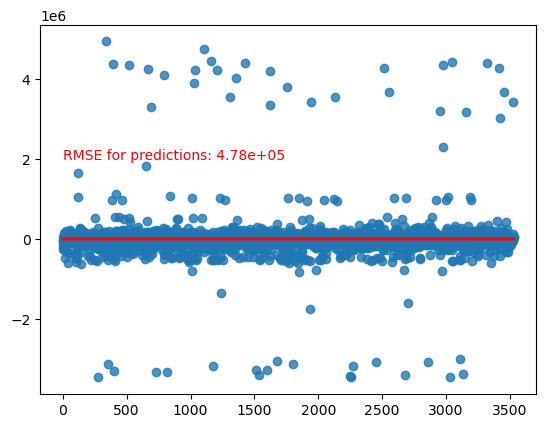

In [513]:
df = all_data_df.drop(labels=["alpha-3", "region", "data_year"], axis=1).dropna()

#'agricaltural_land_perc', 'forest_land_perc', 'electric_access_perc', 'co2_emission_kt', 'agri_forest_value_added', 'industry_value_added', 'gdp_per_capita', 'total_pop'
#industry_value_added + electric_access_perc + agricaltural_land_perc + forest_land_perc + 1
mdl = smf.ols("co2_emission_kt ~ agri_forest_value_added + gdp_per_capita + total_pop - 1 ", data=df).fit()
display(mdl.summary())
residuals = pd.Series(mdl.resid).sample(frac=1, replace=False).reset_index().drop(labels="index", axis=1)
ax = sns.regplot(x=residuals.index.values, y=residuals.values, lowess=True, line_kws={"color": "red"})

ax.annotate(xy=(0, 2e6), text="RMSE for predictions: {:.2e}".format(np.sqrt(mdl.mse_resid)), color="red")

In [514]:
df = all_data_df.drop(labels=["alpha-3", "region", "data_year"], axis=1).dropna()
X = df.drop(labels=["co2_emission_kt", "transformed_co2_emission_kt"], axis=1).values
y = df["co2_emission_kt"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2022)


random_forest = RandomForestRegressor(criterion="squared_error", bootstrap=True, n_jobs=-3, random_state=2022)

param_distributions = {
    "n_estimators": np.linspace(5, 500, 10).astype(np.int32),
    "max_depth": np.linspace(5, 75, 10).astype(np.int32),
    "min_samples_leaf": np.linspace(5, 350, 10).astype(np.int32),
    "max_features": np.linspace(0.1, 1, 5)
}

random_search_random_forest = RandomizedSearchCV(random_forest, param_distributions=param_distributions, scoring="neg_mean_poisson_deviance", cv=10, n_jobs=-3, n_iter=75, random_state=2022)
random_search_random_forest.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=RandomForestRegressor(n_jobs=-3,
                                                   random_state=2022),
                   n_iter=75, n_jobs=-3,
                   param_distributions={'max_depth': array([ 5, 12, 20, 28, 36, 43, 51, 59, 67, 75], dtype=int32),
                                        'max_features': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'min_samples_leaf': array([  5,  43,  81, 120, 158, 196, 235, 273, 311, 350], dtype=int32),
                                        'n_estimators': array([  5,  60, 115, 170, 225, 280, 335, 390, 445, 500], dtype=int32)},
                   random_state=2022, scoring='neg_mean_poisson_deviance')

In [515]:
dt = DecisionTreeRegressor(criterion="squared_error", random_state=2022)

param_distributions = {
    "max_depth":np.linspace(5, 100, 10).astype(np.int32),
    "min_samples_split":np.linspace(15, 400, 10).astype(np.int32),
    "min_samples_leaf":np.linspace(10, 300, 10).astype(np.int32)
}

random_search_decision_tree = RandomizedSearchCV(dt, param_distributions=param_distributions, scoring="neg_mean_poisson_deviance", cv=10, n_jobs=-3, n_iter=75, random_state=2022)
random_search_decision_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=2022),
                   n_iter=75, n_jobs=-3,
                   param_distributions={'max_depth': array([  5,  15,  26,  36,  47,  57,  68,  78,  89, 100], dtype=int32),
                                        'min_samples_leaf': array([ 10,  42,  74, 106, 138, 171, 203, 235, 267, 300], dtype=int32),
                                        'min_samples_split': array([ 15,  57, 100, 143, 186, 228, 271, 314, 357, 400], dtype=int32)},
                   random_state=2022, scoring='neg_mean_poisson_deviance')

In [516]:
base_estimator = random_search_decision_tree.best_estimator_ #Daha önce elde ettiğimiz ideal ağacı kullandığımzda AdaBoosta ait sonucun iyileştiği görülmektedir. Decision tree için ekstra grid search yapılmamıştır.
adaboost = AdaBoostRegressor(base_estimator, random_state=2022)

param_distributions = {
    "n_estimators": np.linspace(5, 500, 10).astype(np.int32),
    "learning_rate": np.logspace(-1, 3, 10)
}

random_search_adaboost_fresh_dt = RandomizedSearchCV(adaboost, param_distributions=param_distributions, scoring="neg_mean_poisson_deviance", cv=10, n_jobs=-3, n_iter=75, random_state=2022)
random_search_adaboost_fresh_dt.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=78,
                                                                                    min_samples_leaf=10,
                                                                                    min_samples_split=57,
                                                                                    random_state=2022),
                                               random_state=2022),
                   n_iter=75, n_jobs=-3,
                   param_distributions={'learning_rate': array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03]),
                                        'n_estimators': array([  5,  60, 115, 170, 225, 280, 335, 390, 445, 500], dtype=int32)},
                   random_state=2022, scoring='neg_mean_poisson_deviance')

100%|██████████| 3/3 [00:00<00:00,  6.63it/s]

Train Results:
Decision_Tree için elde edilen R^2 değeri: 7.56e-01
Decision_Tree için elde edilen RMSE değeri: 3.69e+05


Test Results:
Decision_Tree için elde edilen R^2 değeri: 7.10e-01
Decision_Tree için elde edilen RMSE değeri: 4.06e+05

**************************************************

Train Results:
Random_Forest için elde edilen R^2 değeri: 9.94e-01
Random_Forest için elde edilen RMSE değeri: 5.85e+04


Test Results:
Random_Forest için elde edilen R^2 değeri: 9.92e-01
Random_Forest için elde edilen RMSE değeri: 6.72e+04

**************************************************

Train Results:
Adaboost_Best_Dt için elde edilen R^2 değeri: 1.00e+00
Adaboost_Best_Dt için elde edilen RMSE değeri: 1.26e+04


Test Results:
Adaboost_Best_Dt için elde edilen R^2 değeri: 9.98e-01
Adaboost_Best_Dt için elde edilen RMSE değeri: 3.72e+04

**************************************************



,Decision_Tree,Random_Forest,Adaboost_Best_Dt
Split_0_Test_Score,143.75,69.04,73.75
Split_1_Test_Score,149.41,42.58,54.69
Split_2_Test_Score,203.04,63.11,49.42
Split_3_Test_Score,162.96,42.12,57.79
Split_4_Test_Score,173.64,63.61,60.58
Split_5_Test_Score,147.86,58.02,72.52
Split_6_Test_Score,260.34,76.33,64.85
Split_7_Test_Score,225.60,86.72,69.55
Split_8_Test_Score,268.06,78.58,57.27
Split_9_Test_Score,226.19,65.98,50.35


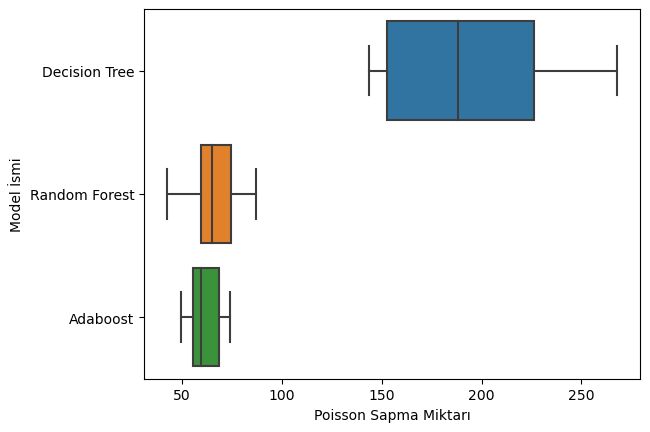

In [517]:
model_list = {
    "Decision_Tree": random_search_decision_tree,
    "Random_Forest": random_search_random_forest,
    "Adaboost_Best_Dt": random_search_adaboost_fresh_dt
}

cv_results = pd.DataFrame(index=["Split_{:d}_Test_Score".format(i) for i in range(0, 10)])
coef_of_determination_test = pd.Series(dtype=np.float64)
MSE_scores_test = pd.Series(dtype=np.float64)

coef_of_determination_train = pd.Series(dtype=np.float64)
MSE_scores_train = pd.Series(dtype=np.float64)

column_range_for_cv_cols = -3 - 10

for model in tqdm(model_list.keys()):
    temp_df = pd.DataFrame(model_list[model].cv_results_).sort_values(by="rank_test_score")

    cv_results[model] = np.sqrt(np.abs(temp_df.iloc[0, column_range_for_cv_cols:-3].values).astype(np.float64))
    
    coef_of_determination_test[model] = model_list[model].best_estimator_.score(X_test, y_test)
    y_pred = model_list[model].best_estimator_.predict(X_test)
    MSE_scores_test[model] = np.sqrt(MSE(y_test, y_pred))

    coef_of_determination_train[model] = model_list[model].best_estimator_.score(X_train, y_train)
    y_pred = model_list[model].best_estimator_.predict(X_train)
    MSE_scores_train[model] = np.sqrt(MSE(y_train, y_pred))       



for model in coef_of_determination_test.index.values:
    print("Train Results:")
    print("{:s} için elde edilen R^2 değeri: {:.2e}".format(model, coef_of_determination_train[model]))
    print("{:s} için elde edilen RMSE değeri: {:.2e}".format(model, MSE_scores_train[model]))

    print("\n")

    print("Test Results:")
    print("{:s} için elde edilen R^2 değeri: {:.2e}".format(model, coef_of_determination_test[model]))
    print("{:s} için elde edilen RMSE değeri: {:.2e}".format(model, MSE_scores_test[model]))
    print("\n" + "*"*50 + "\n")

display(cv_results)

ax = sns.boxplot(data=cv_results.melt(), y="variable", x="value")
ax.set_xlabel("Poisson Sapma Miktarı")
ax.set_ylabel("Model İsmi")
ax.set_yticks(labels=["Decision Tree", "Random Forest", "Adaboost"], ticks=[0, 1, 2])


In [518]:
display(cv_results)

#‘less’: the mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample.
t_stat, p_value = stats.ttest_ind(cv_results["Random_Forest"].values, cv_results["Adaboost_Best_Dt"].values, alternative="greater", equal_var=False)
display("{:.2f}-{:.2f}".format(t_stat, p_value))

,Decision_Tree,Random_Forest,Adaboost_Best_Dt
Split_0_Test_Score,143.75,69.04,73.75
Split_1_Test_Score,149.41,42.58,54.69
Split_2_Test_Score,203.04,63.11,49.42
Split_3_Test_Score,162.96,42.12,57.79
Split_4_Test_Score,173.64,63.61,60.58
Split_5_Test_Score,147.86,58.02,72.52
Split_6_Test_Score,260.34,76.33,64.85
Split_7_Test_Score,225.60,86.72,69.55
Split_8_Test_Score,268.06,78.58,57.27
Split_9_Test_Score,226.19,65.98,50.35


'0.66-0.26'

In [519]:
best_model = random_search_adaboost_fresh_dt.best_estimator_
feature_list = ["Tarımsal Alan Yüzdesi", "Ormanlık Alan Yüzdesi", "Elektrik Erişimi Yüzdesi",
                "Tarım ve Orman Sektör Kazancı", "Sanayi Sektör Kazancı", "Kişi Başı GSMH",
                "Toplam Nufüs"
                ]

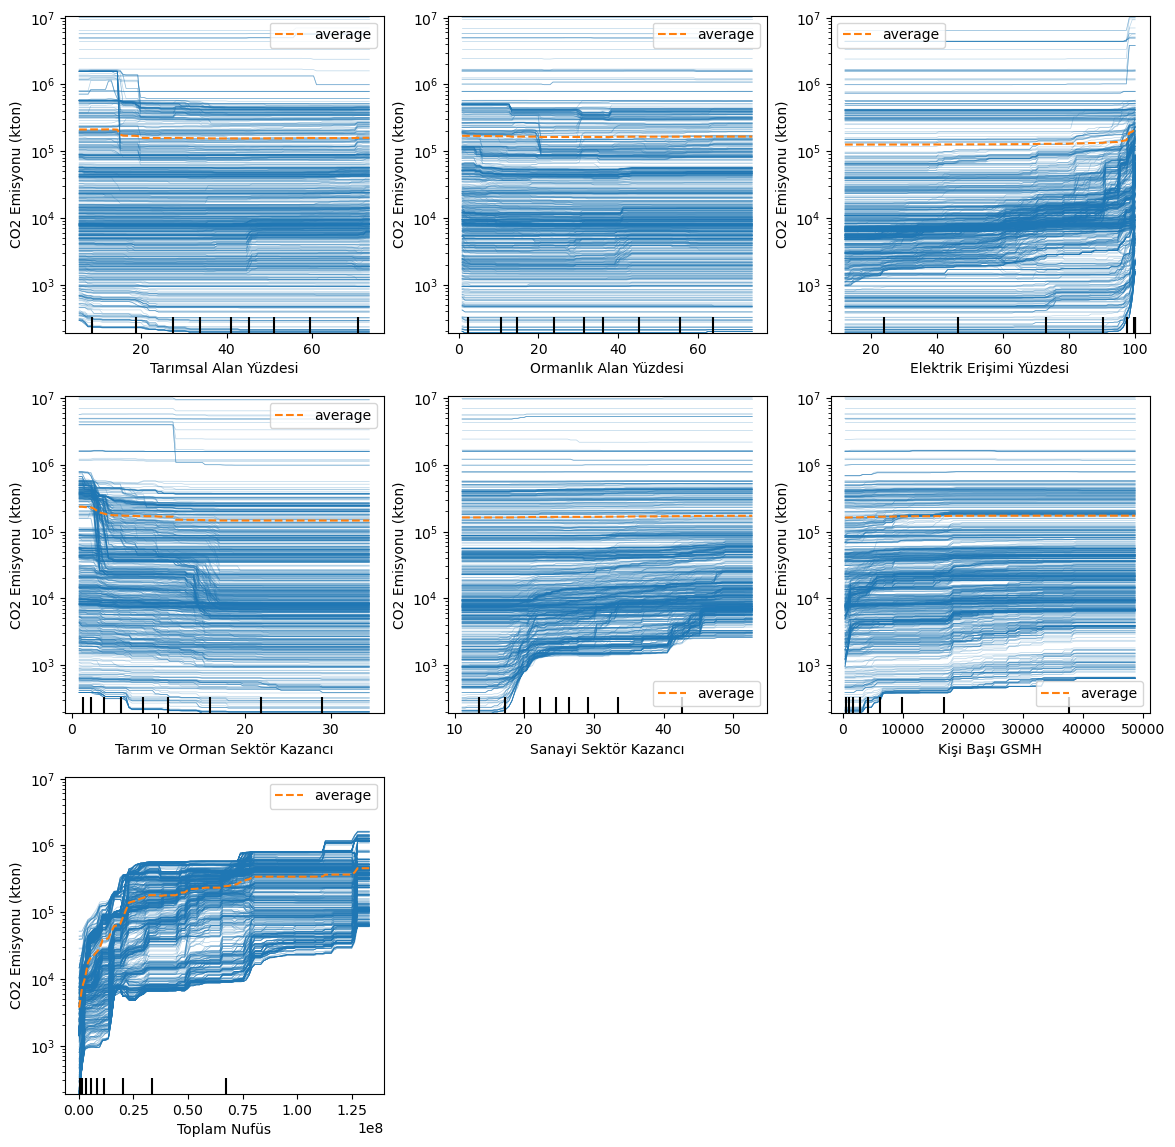

In [520]:
fig, ax = plt.subplots()
plotter = PartialDependenceDisplay.from_estimator(best_model, X_train, [i for i in range(len(feature_list))], n_jobs=-3, ax=ax, kind="both", random_state=2022)
for ax, feature in zip(plotter.axes_.ravel(), feature_list):
    ax.set_xlabel(feature)
    ax.set_ylabel("CO2 Emisyonu (kton)")
    ax.semilogy()      

fig.set_size_inches(14, 14)

,Feature_name,Feature_importance_mean,Feature_importance_std
5,Kişi Başı GSMH,"212,860,563.77","12,645,689.36"
4,Sanayi Sektör Kazancı,"492,875,882.72","61,325,537.80"
1,Ormanlık Alan Yüzdesi,"515,673,862.08","51,784,831.13"
0,Tarımsal Alan Yüzdesi,"16,495,794,971.26","1,857,034,039.50"
3,Tarım ve Orman Sektör Kazancı,"29,149,087,655.28","5,275,861,478.63"
2,Elektrik Erişimi Yüzdesi,"67,763,068,258.19","17,726,521,717.65"
6,Toplam Nufüs,"1,040,245,524,926.63","56,427,521,583.68"


Text(0.5, 0, 'Bağıl Nitelik Önemi')

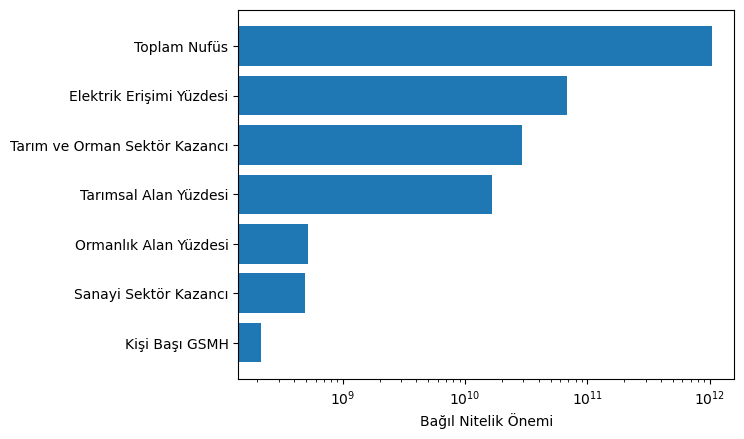

In [521]:
importance_analysis = permutation_importance(best_model, X_train, y_train, n_repeats=30, n_jobs=-3, scoring="neg_mean_squared_error", random_state=2022)

importance_analysis_df = pd.DataFrame(
{
"Feature_name": feature_list,
"Feature_importance_mean": importance_analysis.importances_mean,
"Feature_importance_std": importance_analysis.importances_std
}
).sort_values(by="Feature_importance_mean")

display(importance_analysis_df)
fig, ax = plt.subplots()
ax.barh(y=importance_analysis_df.Feature_name, width=importance_analysis_df.Feature_importance_mean)
ax.semilogx()
ax.set_xlabel("Bağıl Nitelik Önemi")

In [523]:
X_train_selected = X_train[:, [0, 2, 3, 6]]
X_test_selected = X_test[:, [0, 2, 3, 6]]

dt_selected = DecisionTreeRegressor(random_state=2022)

param_grid = {
    "max_depth":np.linspace(5, 50, 5).astype(np.int32),
    "min_samples_leaf":np.linspace(5, 75, 5).astype(np.int32),
    "criterion": ["squared_error", "poisson", "absolute_error"]
}

grid_search_decision_tree = GridSearchCV(dt_selected, param_grid=param_grid, scoring="neg_mean_poisson_deviance", cv=7, n_jobs=-3)
grid_search_decision_tree.fit(X_train_selected, y_train)

base_estimator = grid_search_decision_tree.best_estimator_ #Daha önce elde ettiğimiz ideal ağacı kullandığımzda AdaBoosta ait sonucun iyileştiği görülmektedir. Decision tree için ekstra grid search yapılmamıştır.
adaboost_selected = AdaBoostRegressor(base_estimator, random_state=2022)

param_grid = {
    "n_estimators": np.linspace(5, 500, 5).astype(np.int32),
    "learning_rate": np.logspace(-2, 1, 5),
    "loss": ["linear", "square", "exponential"]
}

grid_search_adaboost_selected = GridSearchCV(adaboost_selected, param_grid=param_grid, scoring="neg_mean_poisson_deviance", cv=7, n_jobs=-3)
grid_search_adaboost_selected.fit(X_train_selected, y_train)

GridSearchCV(cv=7,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='absolute_error',
                                                                              max_depth=27,
                                                                              min_samples_leaf=5,
                                                                              random_state=2022),
                                         random_state=2022),
             n_jobs=-3,
             param_grid={'learning_rate': array([ 0.01      ,  0.05623413,  0.31622777,  1.77827941, 10.        ]),
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': array([  5, 128, 252, 376, 500], dtype=int32)},
             scoring='neg_mean_poisson_deviance')

100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

Train Results:
Adaboost_Best_Dt için elde edilen R^2 değeri: 1.00e+00
Adaboost_Best_Dt için elde edilen RMSE değeri: 2.94e+03


Test Results:
Adaboost_Best_Dt için elde edilen R^2 değeri: 9.97e-01
Adaboost_Best_Dt için elde edilen RMSE değeri: 4.34e+04

**************************************************



,Adaboost_Best_Dt
Split_0_Test_Score,40.60
Split_1_Test_Score,33.38
Split_2_Test_Score,56.10
Split_3_Test_Score,47.19
Split_4_Test_Score,60.21
Split_5_Test_Score,49.03
Split_6_Test_Score,29.35


<AxesSubplot:xlabel='variable', ylabel='value'>

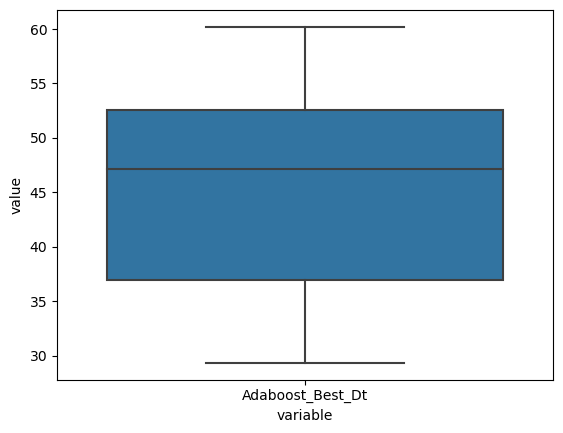

In [524]:
model_list = {
    "Adaboost_Best_Dt": grid_search_adaboost_selected
}

cv_results = pd.DataFrame(index=["Split_{:d}_Test_Score".format(i) for i in range(0, 7)])
coef_of_determination_test = pd.Series(dtype=np.float64)
MSE_scores_test = pd.Series(dtype=np.float64)

coef_of_determination_train = pd.Series(dtype=np.float64)
MSE_scores_train = pd.Series(dtype=np.float64)

column_range_for_cv_cols = -3 - 7

for model in tqdm(model_list.keys()):
    temp_df = pd.DataFrame(model_list[model].cv_results_).sort_values(by="rank_test_score")

    cv_results[model] = np.sqrt(np.abs(temp_df.iloc[0, column_range_for_cv_cols:-3].values).astype(np.float64))
    
    coef_of_determination_test[model] = model_list[model].best_estimator_.score(X_test_selected, y_test)
    y_pred = model_list[model].best_estimator_.predict(X_test_selected)
    MSE_scores_test[model] = np.sqrt(MSE(y_test, y_pred))

    coef_of_determination_train[model] = model_list[model].best_estimator_.score(X_train_selected, y_train)
    y_pred = model_list[model].best_estimator_.predict(X_train_selected)
    MSE_scores_train[model] = np.sqrt(MSE(y_train, y_pred))


for model in coef_of_determination_test.index.values:
    print("Train Results:")
    print("{:s} için elde edilen R^2 değeri: {:.2e}".format(model, coef_of_determination_train[model]))
    print("{:s} için elde edilen RMSE değeri: {:.2e}".format(model, MSE_scores_train[model]))

    print("\n")

    print("Test Results:")
    print("{:s} için elde edilen R^2 değeri: {:.2e}".format(model, coef_of_determination_test[model]))
    print("{:s} için elde edilen RMSE değeri: {:.2e}".format(model, MSE_scores_test[model]))
    print("\n" + "*"*50 + "\n")

display(cv_results)

sns.boxplot(data=cv_results.melt(), x="variable", y="value")

'RMSE: 4.34e+04'

,Predictions,True_Values,Residuals
136,"7,719,069.82","8,474,919.92","755,850.10"
343,"4,415,910.16","5,124,819.82","708,909.67"
740,"1,972,430.05","2,147,110.11","174,680.05"
474,"9,874,660.16","9,984,570.31","109,910.16"
241,"4,819,370.12","4,894,500.00","75,129.88"
...,...,...,...
642,"379,989.99","239,980.00","-140,009.99"
387,"1,564,880.00","1,424,380.00","-140,500.00"
703,"10,006,669.92","9,861,099.61","-145,570.31"
340,"3,810,060.06","3,529,080.00","-280,980.06"


,index,Residuals
0,95,"5,575.00"
1,504,"1,640.00"
2,152,"5,350.00"
3,580,"7,140.00"
4,595,270.00
...,...,...
878,874,"1,030.00"
879,168,"9,060.00"
880,99,-350.00
881,454,"-5,540.00"


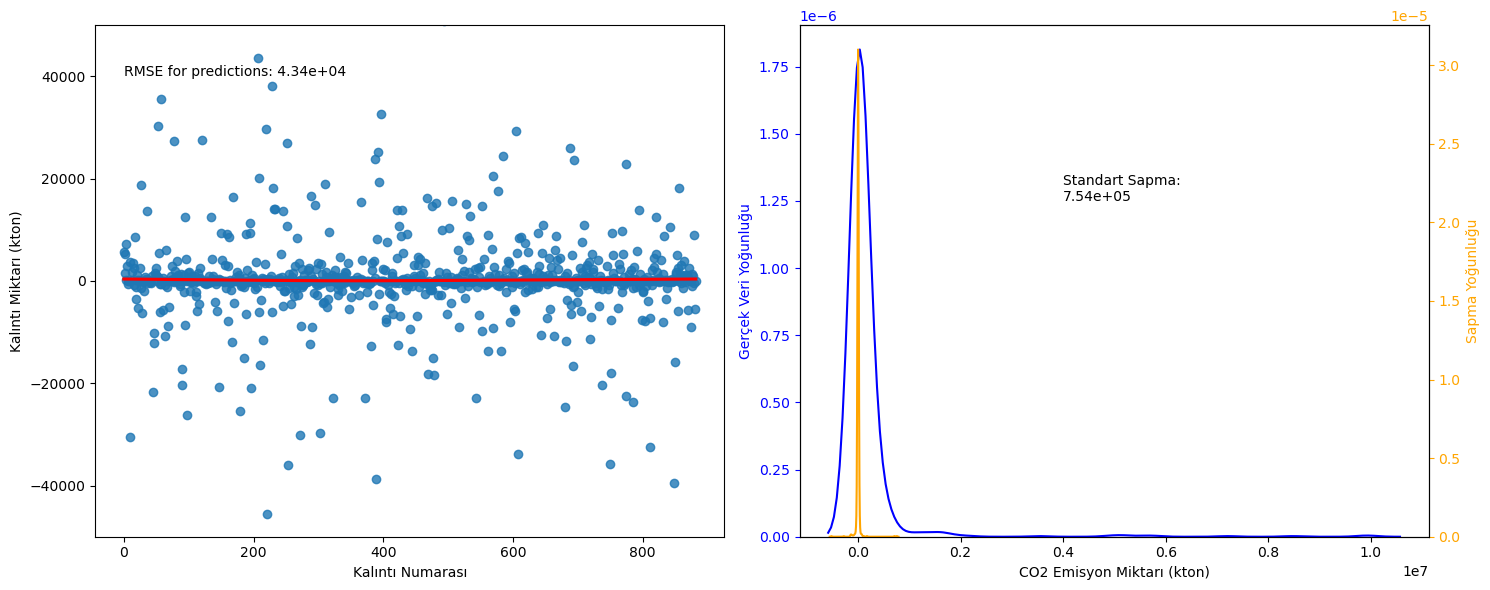

In [525]:
best_model = grid_search_adaboost_selected
results = pd.DataFrame({
    "Predictions": best_model.predict(X_test_selected),
    "True_Values": y_test
})

results = results.assign(Residuals=(results.True_Values - results.Predictions))
display("RMSE: {:.2e}".format(np.sqrt(MSE(results.True_Values, results.Predictions))))
display(results.sort_values(by="Residuals", ascending=False))

residuals = results["Residuals"].sample(frac=1, replace=False).reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2)
display(residuals)
sns.regplot(x=residuals.index.values, y=residuals.Residuals.values, lowess=True, line_kws={"color": "red"}, ax=ax[0])
ax[0].annotate(xy=(0, 4e4), text="RMSE for predictions: {:.2e}".format(np.sqrt(MSE(results.True_Values, results.Predictions))), color="black")
ax[0].set_ylim(-5e4, 5e4)
ax[0].set_xlabel("Kalıntı Numarası")
ax[0].set_ylabel("Kalıntı Miktarı (kton)")

ax1_rep = ax[1].twinx()
sns.kdeplot(data=results, x="True_Values", ax=ax[1], color="blue", label="Gerçek Veri")
ax[1].annotate(xy=(0.4e7, 1.25e-6), text="Standart Sapma:\n{:.2e}".format(np.std(results.True_Values)), color="black")
ax[1].set_xlabel("CO2 Emisyon Miktarı (kton)")
ax[1].set_ylabel("Gerçek Veri Yoğunluğu", color="blue")
ax[1].tick_params(axis="y", color="blue", labelcolor="blue")

sns.kdeplot(data=results, x="Residuals", ax=ax1_rep, label="Kalıntı Miktarı", color="orange")
ax1_rep.set_ylabel("Sapma Yoğunluğu", color="orange")
ax1_rep.tick_params(axis="y", color="orange", labelcolor="orange")



fig.set_size_inches(15, 6)
fig.tight_layout()